# RAG for rules

In [1]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1")

In [2]:
from langchain_ollama import OllamaEmbeddings

# embeddings = OllamaEmbeddings(model="snowflake-arctic-embed2")
embeddings = OllamaEmbeddings(model="mxbai-embed-large")


In [3]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [4]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "../data/MagicCompRules 20241108.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

295


In [5]:
print(f"{docs[0].page_content[:200]}\n")
print(docs[0].metadata)

Magic: The Gathering Comprehensive Rules 
 
These rules are effective as of November 8, 2024. 
 
Introduction 
 
This document is the ultimate authority for Magic: The Gathering® competitive game play

{'source': '../data/MagicCompRules 20241108.pdf', 'page': 0}


In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

1236

In [7]:
vector_1 = embeddings.embed_query(all_splits[0].page_content)
vector_2 = embeddings.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

Generated vectors of length 1024

[0.008813284, -0.024318807, 0.032390587, 0.01052019, 0.02036579, -0.03691951, 0.034285244, -0.023193588, -0.013136297, 0.083584286]


In [8]:
_ = vector_store.add_documents(documents=all_splits)

In [9]:
results = vector_store.similarity_search(
    "How many cards must a standard constructed deck contain?"
)

print(results[0])

page_content='other than basic land cards. For the purposes of deck construction, cards with interchangeable 
names have the same English name (see rule 201.3). 
 
100.2b In limited play (a way of playing in which each player gets the same quantity of unopened 
Magic product such as booster packs and creates their own deck using only this product and 
basic land cards), each deck has a minimum deck size of 40 cards. A limited deck may contain 
as many duplicates of a card as are included with the product. 
 
100.2c Commander decks are subject to additional deckbuilding restrictions and requirements. See 
rule 903, “Commander,” for details. 
 
100.2d Some formats and casual play variants allow players to use a supplementary deck of 
nontraditional Magic cards (see rule 108.2a). These supplementary decks have their own deck 
construction rules. See rule 717, “Attraction Cards;” rule 901, “Planechase;” and rule 904, 
“Archenemy.”' metadata={'source': '../data/MagicCompRules 20241108.pdf',

In [10]:
results = vector_store.similarity_search(
    "How many types of spells are there?"
)

print(results[0])

page_content='Zariel. 
 
205.3k Instants and sorceries share their lists of subtypes; these subtypes are called spell types.  The 
spell types are Adventure, Arcane, Lesson, and Trap. 
 
205.3m Creatures and kindreds share their lists of subtypes; these subtypes are called creature 
types. One creature type is two words long: Time Lord. All other creature types are one word 
long: Advisor, Aetherborn, Alien, Ally, Angel, Antelope, Ape, Archer, Archon, Armadillo, 
Army, Artificer, Assassin, Assembly-Worker, Astartes, Atog, Aurochs, Avatar, Azra, Badger, 
Balloon, Barbarian, Bard, Basilisk, Bat, Bear, Beast, Beaver, Beeble, Beholder, Berserker, Bird, 
Blinkmoth, Boar, Bringer, Brushwagg, Camarid, Camel, Capybara, Caribou, Carrier, Cat, 
Centaur, Child, Chimera, Citizen, Cleric, Clown, Cockatrice, Construct, Coward, Coyote, Crab, 
Crocodile, C’tan, Custodes, Cyberman, Cyclops, Dalek, Dauthi, Demigod, Demon, Deserter,' metadata={'source': '../data/MagicCompRules 20241108.pdf', 'page': 49, 

In [11]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [12]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [14]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

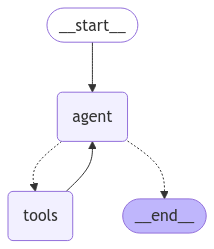

In [15]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [16]:
llm.invoke("In Magic The Gathering, how many cards must a standard constructed deck contain?")

AIMessage(content="A Standard Constructed deck in Magic: The Gathering must contain exactly 60 cards. This is specified by the official rules of Wizards of the Coast, the game's publisher.\n\nIt's worth noting that while this is the minimum number of cards required, most players build their decks with more than 60 cards to include a sideboard (up to 15 additional cards). However, the actual deck played during competition must still contain only 60 cards.", additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-31T06:07:04.908619393Z', 'done': True, 'done_reason': 'stop', 'total_duration': 876369642, 'load_duration': 16581740, 'prompt_eval_count': 25, 'prompt_eval_duration': 5000000, 'eval_count': 91, 'eval_duration': 853000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-99acc2fe-3a80-4345-bb3e-c609bf78c458-0', usage_metadata={'input_tokens': 25, 'output_tokens': 91, 'total_tokens': 116})

In [18]:
llm.invoke("What is the latest set in Magic The Gathering, that you are aware of?")

AIMessage(content='According to my knowledge cutoff (which might be outdated), the latest sets in Magic: The Gathering are:\n\n**Standard Sets:**\n\n1. **Kaldheim** (February 2021)\n2. **Strixhaven: School of Mages** (April 2021)\n3. **Core Set 2024** (July 2022) - Note that this set is not a traditional "set" in the sense that it\'s a rotating standard format, but rather a collection of cards from various sets.\n\n**Modern Sets:**\n\n1. **Kaldheim** (February 2021)\n2. **Strixhaven: School of Mages** (April 2021)\n\n**Commander and Other Formats:**\n\n1. **Kaldheim Commander** (February 2021) - A special set designed for the Commander format.\n2. **Secret Lair** sets (various release dates, but often around the same time as a standard or modern set)\n3. **Zendikar Rising Commander** (September 2020)\n\nPlease note that new sets are released regularly by Wizards of the Coast, so this information might be outdated. I recommend checking official sources like [Magic: The Gathering\'s webs

In [17]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "In Magic The Gathering, how many cards must a standard constructed deck contain?"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

In Magic The Gathering, how many cards must a standard constructed deck contain?
================================== Ai Message ==================================
Tool Calls:
  retrieve (7f370ff6-408d-4f35-b4d8-7f2a32984b65)
 Call ID: 7f370ff6-408d-4f35-b4d8-7f2a32984b65
  Args:
    query: Magic The Gathering, Standard Constructed Deck Card Count
================================= Tool Message =================================
Name: retrieve

Source: {'source': '../data/MagicCompRules 20241108.pdf', 'page': 4, 'start_index': 810}
Content: other than basic land cards. For the purposes of deck construction, cards with interchangeable 
names have the same English name (see rule 201.3). 
 
100.2b In limited play (a way of playing in which each player gets the same quantity of unopened 
Magic product such as booster packs and creates their own deck using only this product and 
basic land cards), each deck has a 

In [27]:
from pathlib import Path

from langchain_community.document_loaders import PyPDFLoader
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import BaseTool
from typing import Optional, Type

from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field




In [44]:
class StrQuery(BaseModel):
    query: str = Field(description="Retrieval query")

class RulesRetriever(BaseTool):
    rules_path: str
    embeddings:OllamaEmbeddings
    vector_store: None|InMemoryVectorStore = None

    name: str = "RulesRetriever"
    description: str = "Provides relevant information for the latest Magic: The Gathering rules, as of November 2024."
    args_schema: Type[BaseModel] = StrQuery

    def __init__(self, rules_path: Path | str, embed_model: str = "snowflake-arctic-embed2"):
        super().__init__(rules_path=str(rules_path), 
                         embeddings=OllamaEmbeddings(model=embed_model))
        self.create_storage()

    def create_storage(self) -> None:
        self.vector_store =InMemoryVectorStore(self.embeddings)
        loader = PyPDFLoader(self.rules_path)
        docs = loader.load()
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
        all_splits = text_splitter.split_documents(docs)
        print(f"Loaded {len(all_splits)} document splits.")
        self.vector_store.add_documents(documents=all_splits)

    def _run(self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None) -> tuple[str, list]:
        """Retrieve information related to a query."""
        retrieved_docs = self.vector_store.similarity_search(query, k=2)
        serialized = "\n\n".join((f"Source: {doc.metadata}\n" f"Content: {doc.page_content}") for doc in retrieved_docs)
        return serialized, retrieved_docs

In [45]:
retriever = RulesRetriever(rules_path="../data/MagicCompRules 20241108.pdf")

Loaded 1236 document splits.


In [46]:
retrieve.invoke("In Magic The Gathering, how many cards must a standard constructed deck contain?")

"Source: {'source': '../data/MagicCompRules 20241108.pdf', 'page': 4, 'start_index': 810}\nContent: other than basic land cards. For the purposes of deck construction, cards with interchangeable \nnames have the same English name (see rule 201.3). \n \n100.2b In limited play (a way of playing in which each player gets the same quantity of unopened \nMagic product such as booster packs and creates their own deck using only this product and \nbasic land cards), each deck has a minimum deck size of 40 cards. A limited deck may contain \nas many duplicates of a card as are included with the product. \n \n100.2c Commander decks are subject to additional deckbuilding restrictions and requirements. See \nrule 903, “Commander,” for details. \n \n100.2d Some formats and casual play variants allow players to use a supplementary deck of \nnontraditional Magic cards (see rule 108.2a). These supplementary decks have their own deck \nconstruction rules. See rule 717, “Attraction Cards;” rule 901, “P

In [48]:
memory = MemorySaver()
agent_executor = create_react_agent(llm, [retriever], checkpointer=memory)
config = {"configurable": {"thread_id": "test_rules_retriever"}}


In [52]:
input_message = (
    "In Magic The Gathering, how many cards must a standard constructed deck contain?"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

In Magic The Gathering, how many cards must a standard constructed deck contain?
================================== Ai Message ==================================
Tool Calls:
  RulesRetriever (b24f0488-1875-4432-8510-28c69767489d)
 Call ID: b24f0488-1875-4432-8510-28c69767489d
  Args:
    query: Magic The Gathering standard constructed deck size
================================= Tool Message =================================
Name: RulesRetriever

("Source: {'source': '../data/MagicCompRules 20241108.pdf', 'page': 4, 'start_index': 810}\nContent: other than basic land cards. For the purposes of deck construction, cards with interchangeable \nnames have the same English name (see rule 201.3). \n \n100.2b In limited play (a way of playing in which each player gets the same quantity of unopened \nMagic product such as booster packs and creates their own deck using only this product and \nbasic land cards), eac